In [ ]:
# !pip install torch

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import models

import torch.nn as nn
import torch.nn.functional as F

import csv
import time
import pandas as pd
from collections import OrderedDict


In [2]:
!nvidia-smi

Thu Feb 27 07:43:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
raw_data_folder = "/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB"
paths = ["/content/drive/MyDrive/sat_classifyer_pytorch/data/train", "/content/drive/MyDrive/sat_classifyer_pytorch/data/test"]
class_list = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
# #split data into train and test

# for folder in paths:
#     for class_ in class_list:
#         directory = os.path.join(folder, class_)
#         if not os.path.exists(directory):
#             os.makedirs(directory)
#             print(f"{directory} created.")
#         else:
#           print(f"{directory} already existed.")


# np.random.seed(1)
# class_dict = {}
# for class_ in class_list:
#     images = os.listdir(os.path.join(raw_data_folder, class_))
#     class_dict.update(dict.fromkeys(images, class_))

#     list_train, list_test = train_test_split(images, test_size=0.2, random_state=1)
#     print (class_)
#     for image in list_train:
#         shutil.copyfile(os.path.join(raw_data_folder, class_, image),os.path.join(paths[0], class_, image))
#     for image in list_test:
#         shutil.copyfile(os.path.join(raw_data_folder, class_, image),os.path.join(paths[1], class_, image))


/content/drive/MyDrive/sat_classifyer_pytorch/data/train/AnnualCrop already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/Forest already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/HerbaceousVegetation already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/Highway already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/Industrial already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/Pasture already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/PermanentCrop already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/Residential already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/River already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/SeaLake already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/test/AnnualCrop already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/test/Forest already

In [5]:
#train and test data directory
train_data_dir = paths[0]
test_data_dir = paths[1]


#load the train and validation data
train_dataset = ImageFolder(train_data_dir,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #resizes images to 150x150 and normalizes them to match imagenet statistics
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [6]:
img, label = train_dataset[0]
print(img.shape,label)

#output :
#torch.Size([3, 150, 150]) 0

torch.Size([3, 224, 224]) 0


In [7]:
print("Follwing classes are there : \n", train_dataset.classes)

#output:
#Follwing classes are there :
# ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

Follwing classes are there : 
 ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Label : AnnualCrop


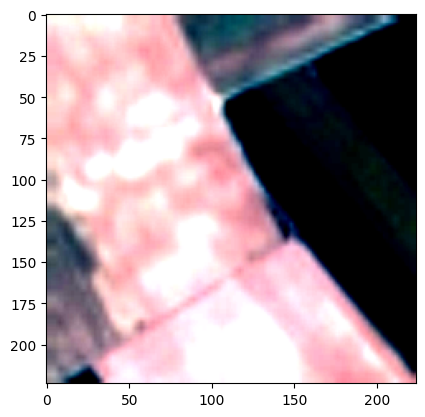

In [8]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_dataset[0])

Label : AnnualCrop


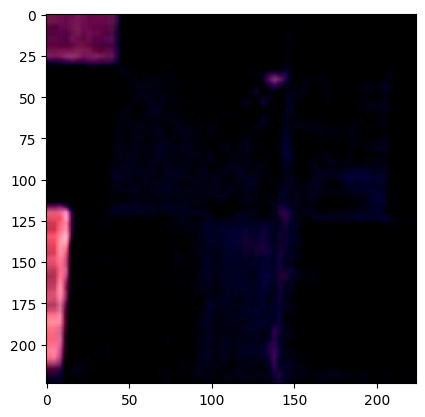

In [ ]:
#display the first image in the dataset
display_img(*test_dataset[0])

In [9]:
batch_size = 32
val_size = int(np.round(0.2 * len(train_dataset)))
train_size = len(train_dataset) - val_size

print(val_size)

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#load the train and validation data into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 2, pin_memory = True)

4323
Length of Train Data : 17293
Length of Validation Data : 4323


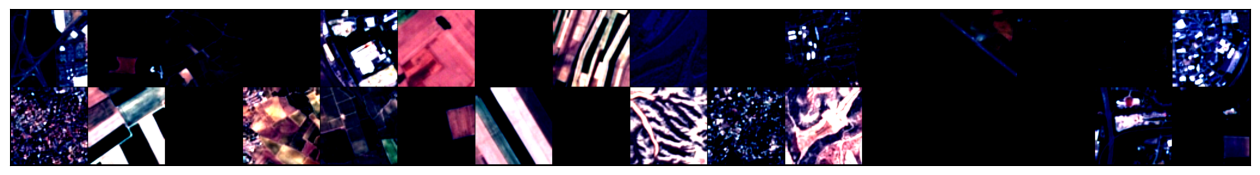

In [10]:
#visualize a batch of images

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

In [11]:
# Define the bottleneck block for deeper ResNet
class Bottleneck(nn.Module):
    expansion = 4  # Expansion factor for the bottleneck

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # First 1x1 convolution reduces dimensionality
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 3x3 convolution applies spatial processing
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Final 1x1 convolution expands dimensionality back
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x  # Preserve input for residual connection
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += identity  # Add residual connection
        out = self.relu(out)
        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [12]:

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])


In [13]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)


In [14]:
# load data into GPU
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = ResNet50().to(device)
device


device(type='cuda')

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def training_step(model, batch, criterion):
    images, labels = batch
    out = model(images)                  # Generate predictions
    loss = criterion(out, labels) # Calculate loss
    return loss


def validation_step(model, batch, criterion):
    images, labels = batch
    out = model(images)                   # Generate predictions
    loss = criterion(out, labels)         # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch, criterion) for batch in val_loader]
    return validation_epoch_end(outputs)

def epoch_end(epoch, result, epoch_time):
    print("Epoch [{}], time: {}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
    epoch, epoch_time, result['train_loss'], result['val_loss'], result['val_acc']))

def fit(epochs, lr, model, train_loader, val_loader, criterion = nn.CrossEntropyLoss(), checkpoint_path = "best_model.pth", opt_func = torch.optim.Adam):

    history = []
    best_loss = float('inf')
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        train_losses = []
        for batch in train_loader:

            loss = training_step(model, batch, criterion)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.item())

        # Compute validation loss
        result = evaluate(model, val_loader)
        result['train_loss'] = np.mean(train_losses)
        # Save the best model checkpoint
        if result["val_loss"] < best_loss:
            best_loss = result["val_loss"]
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1} with validation loss {best_loss:.4f}")
        epoch_time = time.time() - start_time
        epoch_end(epoch, result, epoch_time)
        history.append(result)

    return history

In [26]:
# # train and save model and statistics
# start = time.time()
# output_path = "/content/drive/MyDrive/sat_classifyer_pytorch/250225_ResNet"
# model_name = "best_250225.pth"
# train_from_scratch = True
# num_epochs = 100
# learning_rate = 0.001
# opt_func = torch.optim.Adam
# criterion = nn.CrossEntropyLoss()
# checkpoint_path = os.path.join(output_path, model_name)
# train_from_scratch = True

# # check whether output path exists, otherwise create it
# if not os.path.exists(output_path):
#   os.makedirs(output_path)

# #fitting the model on training data and record the result after each epoch
# history = fit(num_epochs, learning_rate, model, train_dl, val_dl, criterion, checkpoint_path, opt_func)

# convert the history.history dict to a pandas DataFrame:
#lossData = pd.DataFrame(history.history)

#check whether qc file exist, and whether is should be extended or removed
extend_csv = False
qc_path = os.path.join(output_path, "Quality Control")
print(output_path)
print(qc_path)
if os.path.exists(qc_path) and train_from_scratch:
  shutil.rmtree(qc_path)
  os.makedirs(qc_path)
elif os.path.exists(qc_path) and train_from_scratch == False:
  extend_csv = True
if not os.path.exists(qc_path):
  os.makedirs(qc_path)

lossDataCSVpath = os.path.join(qc_path, 'training_evaluation.csv')

if extend_csv:
  #read and extend existing file
  with open(lossDataCSVpath, 'ab') as f:
    writer = csv.writer(f)
    writer.writerow(['loss','val_loss', 'val_acc', 'learning rate'])
    for i in range(len(history.history['loss'])):
      writer.writerow([history.history['loss'][i], history.history['val_loss'][i], history[i]['val_acc'], learning_rate])

else:
  # The training evaluation.csv is created and saved
  with open(lossDataCSVpath, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['loss','val_loss', 'val_acc', 'learning rate'])
    for i, element in enumerate(history):
      writer.writerow([history[i]['train_loss'], history[i]['val_loss'], history[i]['val_acc'], learning_rate])

# Displaying the time elapsed for training
dt = time.time() - start
mins, sec = divmod(dt, 60)
hour, mins = divmod(mins, 60)
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")

/content/drive/MyDrive/sat_classifyer_pytorch/250225_ResNet
/content/drive/MyDrive/sat_classifyer_pytorch/250225_ResNet/Quality Control
Time elapsed: 0.0 hour(s) 0.0 min(s) 29 sec(s)


In [27]:
history

[{'val_loss': 0.5320904850959778,
  'val_acc': 0.8189797401428223,
  'train_loss': 0.614129434506686},
 {'val_loss': 1.1588765382766724,
  'val_acc': 0.6520549058914185,
  'train_loss': 0.50747503308569},
 {'val_loss': 0.8046934008598328,
  'val_acc': 0.7686975002288818,
  'train_loss': 0.44434714197506525},
 {'val_loss': 0.9405640959739685,
  'val_acc': 0.7544905543327332,
  'train_loss': 0.38328252413246416},
 {'val_loss': 0.3949200212955475,
  'val_acc': 0.872708797454834,
  'train_loss': 0.3468673293945309},
 {'val_loss': 0.2776041030883789,
  'val_acc': 0.9040703773498535,
  'train_loss': 0.3014209982896027},
 {'val_loss': 0.2785402834415436,
  'val_acc': 0.8984046578407288,
  'train_loss': 0.27375875116634063},
 {'val_loss': 0.253524512052536,
  'val_acc': 0.910084068775177,
  'train_loss': 0.25073020784752426},
 {'val_loss': 0.2415851652622223,
  'val_acc': 0.9098148345947266,
  'train_loss': 0.2241870005392984},
 {'val_loss': 0.26743999123573303,
  'val_acc': 0.9034598469734192

In [ ]:
# problem with corrupted file: since I cannot see the file in my drive and google drive cannot display hidden files, check whether the file actually

# dir_path = "/content/drive/MyDrive/sat_classifyer_pytorch/data/train/HerbaceousVegetation"
# print(os.listdir(dir_path))

# "HerbaceousVegetation_432.jpg" in os.listdir(dir_path)

['HerbaceousVegetation_984.jpg', 'HerbaceousVegetation_464.jpg', 'HerbaceousVegetation_2056.jpg', 'HerbaceousVegetation_1829.jpg', 'HerbaceousVegetation_2042.jpg', 'HerbaceousVegetation_1600.jpg', 'HerbaceousVegetation_592.jpg', 'HerbaceousVegetation_1805.jpg', 'HerbaceousVegetation_1034.jpg', 'HerbaceousVegetation_1993.jpg', 'HerbaceousVegetation_797.jpg', 'HerbaceousVegetation_2384.jpg', 'HerbaceousVegetation_1999.jpg', 'HerbaceousVegetation_1282.jpg', 'HerbaceousVegetation_782.jpg', 'HerbaceousVegetation_1388.jpg', 'HerbaceousVegetation_2513.jpg', 'HerbaceousVegetation_93.jpg', 'HerbaceousVegetation_1329.jpg', 'HerbaceousVegetation_1308.jpg', 'HerbaceousVegetation_1680.jpg', 'HerbaceousVegetation_1559.jpg', 'HerbaceousVegetation_623.jpg', 'HerbaceousVegetation_2927.jpg', 'HerbaceousVegetation_2043.jpg', 'HerbaceousVegetation_860.jpg', 'HerbaceousVegetation_2978.jpg', 'HerbaceousVegetation_2401.jpg', 'HerbaceousVegetation_1006.jpg', 'HerbaceousVegetation_2420.jpg', 'HerbaceousVegetat

True

In [ ]:
# # check whether file is a valid format

# from imghdr import what

# print(what("/content/drive/MyDrive/sat_classifyer_pytorch/data/train/HerbaceousVegetation/HerbaceousVegetation_432.jpg"))

In [ ]:
# if file is corrupted --> delete file
# file_path = Path("/content/drive/MyDrive/sat_classifyer_pytorch/data/train/HerbaceousVegetation/HerbaceousVegetation_432.jpg")
# file_path.unlink()

In [28]:


def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


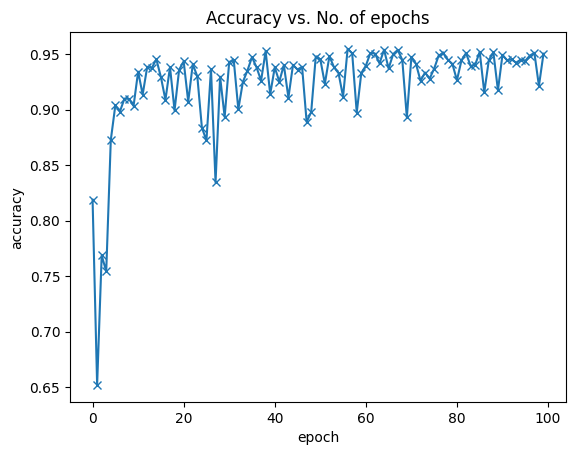

In [29]:
plot_accuracies(history)

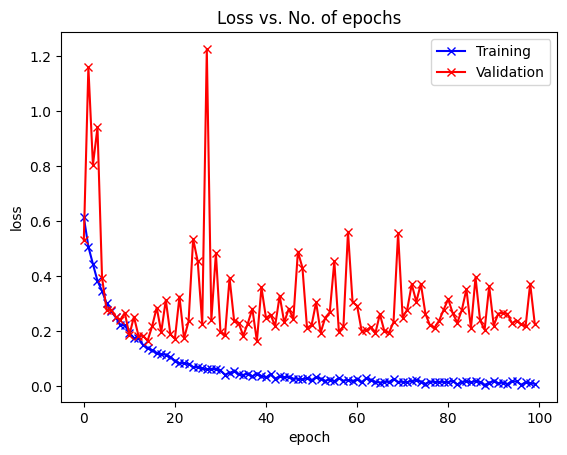

In [30]:
plot_losses(history)

In [ ]:
# saving the model is not necessary since I already saved the one with smallest validation loss during checkpoints
torch.save(model.state_dict(), '/content/drive/MyDrive/sat_classifyer_pytorch/SatelliteClassification.pth')

In [31]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.21107132732868195, 'val_acc': 0.9519839882850647}

In [ ]:
#check whether classes are balanced

In [ ]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]